In [1]:
from audioop import add
import datetime
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.utils import remove_loops
from myst_nb import glue as default_glue
from pkg.data import DATA_VERSION, load_maggot_graph, select_nice_nodes
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.stats import (
    compute_density_adjustment,
    erdos_renyi_test,
    stochastic_block_test,
)
from tqdm import tqdm

set_theme()

t0 = time.time()

DISPLAY_FIGS = True

FILENAME = "thresholding_tests"


def glue(name, var, prefix=None):
    savename = f"{FILENAME}-{name}"
    if prefix is not None:
        savename = prefix + ":" + savename
    default_glue(savename, var, display=False)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, prefix="fig")

    if not DISPLAY_FIGS:
        plt.close()

In [2]:

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
left_mg, right_mg = mg.bisect(lcc=True)
left_nodes = left_mg.nodes
right_nodes = right_mg.nodes

left_adj = left_mg.sum.adj
right_adj = right_mg.sum.adj

GROUP_KEY = "simple_group"

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [3]:


def binarize(A, threshold=None):
    # threshold is the smallest that is kept

    B = A.copy()

    if threshold is not None:
        B[B < threshold] = 0

    return B


rows = []
thresholds = np.arange(1, 10)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj, threshold=threshold)
    right_adj_thresh = binarize(right_adj, threshold=threshold)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": "ER",
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = "DA-SBM"
        else:
            method = "SBM"
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)

integer_results = pd.DataFrame(rows)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.69s/it]


In [4]:


# def plot_thresholding_pvalues(results):
#     fig, ax = plt.subplots(1, 1, figsize=(7, 6))

#     sns.scatterplot(
#         data=results, x="threshold", y="pvalue", hue="method", palette=palette, ax=ax
#     )
#     ax.set(yscale="log", ylabel="p-value", xlabel="Edge weight (# synapses) threshold")
#     ax.get_legend().set_title("Method")
#     ax.axhline(0.05, color="black", linestyle=":")
#     ax.text(ax.get_xlim()[1], 0.05, r"$\alpha = 0.05$", va="center", ha="left")
#     ax.set(xticks=thresholds)

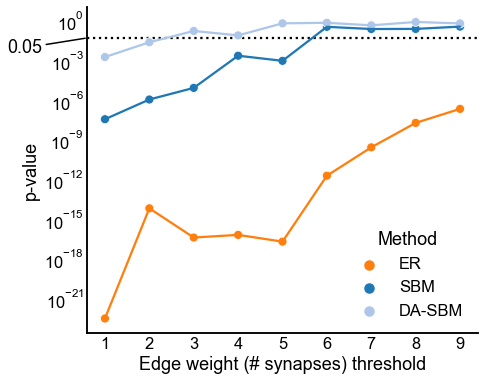

In [5]:
def add_alpha_line(ax):
    ax.axhline(0.05, color="black", linestyle=":", zorder=-1)
    ax.annotate(
        r"0.05",
        (ax.get_xlim()[0], 0.05),
        xytext=(-45, -15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-", color="black"),
        clip_on=False,
        ha="right",
    )


colors = sns.color_palette("tab20")
palette = dict(zip(["SBM", "DA-SBM", "ER"], colors))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))


sns.scatterplot(
    data=integer_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
)
sns.lineplot(
    data=integer_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(yscale="log", ylabel="p-value", xlabel="Edge weight (# synapses) threshold")
ax.get_legend().set_title("Method")
ax.set(xticks=thresholds)
add_alpha_line(ax)

gluefig("integer_threshold_pvalues", fig)

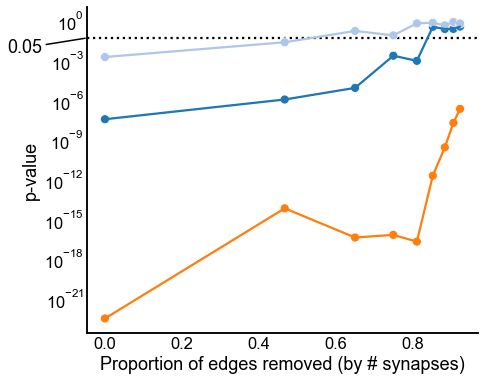

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

colors = sns.color_palette("tab20")
palette = dict(zip(["SBM", "DA-SBM", "ER"], colors))

sns.scatterplot(
    data=integer_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=integer_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(yscale="log", ylabel="p-value", xlabel="Proportion of edges removed (by # synapses)")
add_alpha_line(ax)
gluefig("integer_threshold_pvalues_p_removed", fig)

In [7]:
left_input = (left_nodes["axon_input"] + left_nodes["dendrite_input"]).values
left_input[left_input == 0] = 1
left_adj_input_norm = left_adj / left_input[None, :]

right_input = (right_nodes["axon_input"] + right_nodes["dendrite_input"]).values
right_input[right_input == 0] = 1
right_adj_input_norm = right_adj / right_input[None, :]

In [8]:


rows = []
thresholds = np.linspace(0, 0.03, 21)
for threshold in tqdm(thresholds):
    left_adj_thresh = binarize(left_adj_input_norm, threshold=threshold)
    # p_edges_left = np.count_nonzero(left_adj_thresh) / np.count_nonzero(left_adj)
    right_adj_thresh = binarize(right_adj_input_norm, threshold=threshold)
    # p_edges_right = np.count_nonzero(left_adj_thresh) / np.count_nonzero(left_adj)

    p_edges_removed = 1 - (
        np.count_nonzero(left_adj_thresh) + np.count_nonzero(right_adj_thresh)
    ) / (np.count_nonzero(left_adj) + np.count_nonzero(right_adj))

    stat, pvalue, misc = erdos_renyi_test(left_adj_thresh, right_adj_thresh)
    row = {
        "threshold": threshold,
        "stat": stat,
        "pvalue": pvalue,
        "method": "ER",
        "p_edges_removed": p_edges_removed,
    }
    rows.append(row)

    for adjusted in [False, True]:
        if adjusted:
            method = "DA-SBM"
        else:
            method = "SBM"
        stat, pvalue, misc = stochastic_block_test(
            left_adj_thresh,
            right_adj_thresh,
            left_labels,
            right_labels,
            density_adjustment=adjusted,
        )
        row = {
            "threshold": threshold,
            "adjusted": adjusted,
            "stat": stat,
            "pvalue": pvalue,
            "method": method,
            "p_edges_removed": p_edges_removed,
        }
        rows.append(row)
input_results = pd.DataFrame(rows)
input_results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:02<00:00,  2.99s/it]


,threshold,stat,pvalue,method,p_edges_removed,adjusted
0,0.0000,3.082387e-23,3.082387e-23,ER,0.000000,NaN
1,0.0000,1.258385e-10,3.561229e-08,SBM,0.000000,False
2,0.0000,6.344169e-06,1.793795e-03,DA-SBM,0.000000,True
3,0.0015,5.954349e-24,5.954349e-24,ER,0.005350,NaN
4,0.0015,1.258385e-10,3.561229e-08,SBM,0.005350,False
...,...,...,...,...,...,...
58,0.0285,1.292440e-02,9.248839e-01,SBM,0.818113,False
59,0.0285,7.358936e-03,7.700385e-01,DA-SBM,0.818113,True
60,0.0300,6.647336e-01,6.647336e-01,ER,0.830161,NaN
61,0.0300,3.900540e-02,9.996055e-01,SBM,0.830161,False


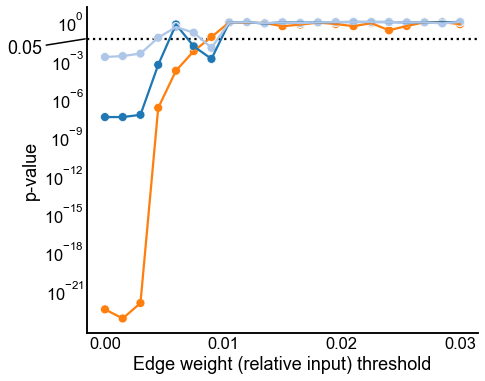

In [9]:


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

colors = sns.color_palette("tab20")
palette = dict(zip(["SBM", "DA-SBM", "ER"], colors))

sns.scatterplot(
    data=input_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=input_results,
    x="threshold",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(yscale="log", ylabel="p-value", xlabel="Edge weight (relative input) threshold")
ax.set(xticks=thresholds, yticks=np.geomspace(1, 1e-21, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
add_alpha_line(ax)

gluefig("input_threshold_pvalues", fig)

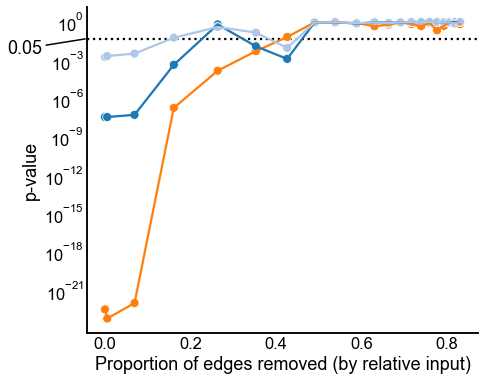

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.scatterplot(
    data=input_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
sns.lineplot(
    data=input_results,
    x="p_edges_removed",
    y="pvalue",
    hue="method",
    palette=palette,
    ax=ax,
    legend=False,
)
ax.set(
    yscale="log",
    ylabel="p-value",
    xlabel="Proportion of edges removed (by relative input)",
    yticks=np.geomspace(1, 1e-21, 8),
)
add_alpha_line(ax)
gluefig("input_threshold_pvalues_p_removed", fig)

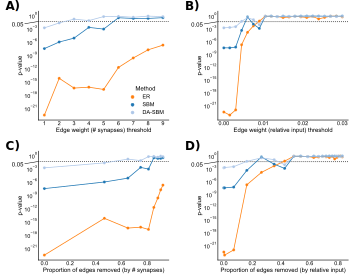

In [11]:

from pkg.plot import SmartSVG
from svgutils.compose import Panel, Text, Figure
from pkg.io import FIG_PATH

FIG_PATH = FIG_PATH / FILENAME

fontsize = 12

int_thresh = SmartSVG(FIG_PATH / "integer_threshold_pvalues.svg")
int_thresh.set_width(200)
int_thresh.move(10, 10)
int_thresh_panel = Panel(int_thresh, Text("A)", 5, 10, size=fontsize, weight="bold"))

input_thresh = SmartSVG(FIG_PATH / "input_threshold_pvalues.svg")
input_thresh.set_width(200)
input_thresh.move(10, 10)
input_thresh_panel = Panel(
    input_thresh, Text("B)", 5, 10, size=fontsize, weight="bold")
)
input_thresh_panel.move(int_thresh.width * 0.9, 0)

int_p_removed = SmartSVG(FIG_PATH / "integer_threshold_pvalues_p_removed.svg")
int_p_removed.set_width(200)
int_p_removed.move(10, 10)
int_p_removed_panel = Panel(
    int_p_removed, Text("C)", 5, 10, size=fontsize, weight="bold")
)
int_p_removed_panel.move(0, int_thresh.height * 0.9)

input_p_removed = SmartSVG(FIG_PATH / "input_threshold_pvalues_p_removed.svg")
input_p_removed.set_width(200)
input_p_removed.move(10, 10)
input_p_removed_panel = Panel(
    input_p_removed, Text("D)", 5, 10, size=fontsize, weight="bold")
)
input_p_removed_panel.move(int_thresh.width * 0.9, int_thresh.height * 0.9)

fig = Figure(
    int_thresh.width * 2 * 0.9,
    int_thresh.height * 2 * 0.9,
    int_thresh_panel,
    input_thresh_panel,
    int_p_removed_panel,
    input_p_removed_panel,
)
fig.save(FIG_PATH / "thresholding_composite.svg")
fig


# #%%
# #%%
# integer_results["Threshold type"] = "Synapse count"
# input_results["Threshold type"] = "Input proportion"
# results = pd.concat((integer_results, input_results))

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.scatterplot(
#     data=results,
#     x="p_edges_removed",
#     y="pvalue",
#     hue="method",
#     style="Threshold type",
#     ax=ax,
# )
# ax.set(yscale='log')
# sns.lineplot(
#     data=results,
#     x="p_edges_removed",
#     y="pvalue",
#     hue="method",
#     style="Threshold type",
#     ax=ax,
# )